In [158]:
#import하기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso

In [159]:
#데이터 준비하기 
train_data = pd.read_csv("E:\데이콘\\전복나이 예측\\데이터\\train.csv")
print(train_data.columns)
train_max_input = train_data[['Gender','Lenght','Diameter','Height','Whole Weight','Shucked Weight','Viscra Weight','Shell Weight']]
train_max_target = train_data['Target'].to_numpy()

ques_data = pd.read_csv("E:\데이콘\\전복나이 예측\\데이터\\test.csv")
ques_input = ques_data[['Gender','Lenght','Diameter','Height','Whole Weight','Shucked Weight','Viscra Weight','Shell Weight']]


Index(['id', 'Gender', 'Lenght', 'Diameter', 'Height', 'Whole Weight',
       'Shucked Weight', 'Viscra Weight', 'Shell Weight', 'Target'],
      dtype='object')


In [160]:
# 데이터 결측지 확인 (제공됨)
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col
missing_col = check_missing_col(train_data)

결측치가 존재하지 않습니다


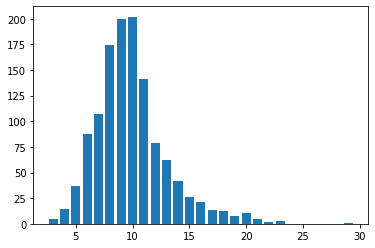

In [161]:
#나이 분포 눈으로 확인
plt.bar(np.unique(train_max_target, return_counts= True)[0],np.unique(train_max_target, return_counts= True)[1])
plt.show()


In [162]:
#성별 원핫 인코딩
train_max_input = pd.concat([train_max_input.drop(['Gender'],axis=1),pd.get_dummies(train_max_input['Gender'])],axis=1)
ques_input =pd.concat([ques_input.drop(['Gender'],axis=1),pd.get_dummies(ques_input['Gender'])],axis=1)
print(train_max_input)

      Lenght  Diameter  Height  Whole Weight  Shucked Weight  Viscra Weight  \
0      0.605     0.470   0.115        1.1140          0.3925         0.2910   
1      0.430     0.315   0.095        0.3780          0.1750         0.0800   
2      0.580     0.490   0.195        1.3165          0.5305         0.2540   
3      0.535     0.405   0.175        1.2705          0.5480         0.3265   
4      0.310     0.235   0.090        0.1270          0.0480         0.0310   
...      ...       ...     ...           ...             ...            ...   
1248   0.190     0.145   0.040        0.0380          0.0165         0.0065   
1249   0.395     0.310   0.085        0.3170          0.1530         0.0505   
1250   0.525     0.410   0.115        0.7745          0.4160         0.1630   
1251   0.445     0.335   0.110        0.4355          0.2025         0.1095   
1252   0.750     0.550   0.195        1.8325          0.8300         0.3660   

      Shell Weight  F  I  M  
0           0.3100  0

In [163]:
#다루기 쉽게 넘파이 배열로 전환
train_max_input = train_max_input.to_numpy()
ques_input = ques_input.to_numpy()

In [164]:
#훈련세트와 테스트 세트 나누기
train_input, test_input, train_target, test_target = train_test_split(train_max_input,train_max_target, test_size=0.2, random_state=42)


In [165]:
#훈련세트랑 검증세트도
sub_input, val_input,sub_target, val_target = train_test_split(train_input,train_target, test_size=0.2,random_state=42)

In [166]:
#특성공학으로 특성 늘리기
poly = PolynomialFeatures(degree=2,include_bias= False)
poly.fit(sub_input)
train_max_poly = poly.transform(train_max_input)
ques_poly = poly.transform(ques_input)
train_poly=poly.transform(train_input)
test_poly = poly.transform(test_input)
sub_poly=poly.transform(sub_input)
val_poly = poly.transform(val_input)

In [167]:
#다중회귀 로 예측
lr = LinearRegression()
lr.fit(sub_poly, sub_target)
print(lr.score(sub_poly,sub_target))
print(lr.score(val_poly,val_target))

0.5955208662377995
0.5149002222383354


In [168]:
#규제 전 전처리 과정
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(sub_poly)
train_scaled = ss.transform(train_poly)
sub_scaled = ss.transform(sub_poly)
val_scaled = ss.transform(val_poly)
train_max_scaled = ss.transform(train_max_poly)
ques_scaled = ss.transform(ques_poly)
test_scaled = ss.transform(test_poly)

In [169]:
#라쏘 규제
lasso = Lasso()
lasso.fit(sub_scaled, sub_target)
print(lasso.score(sub_scaled,sub_target))
print(lasso.score(val_scaled,val_target))

0.2939417139720498
0.2756142064167164


In [170]:
#최적의 alpha값 찾기
sub_scores =[]
val_scores = []
alpha_list = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for alpha in alpha_list:
    lasso= Lasso(alpha=alpha,max_iter=10000)
    lasso.fit(sub_scaled, sub_target)
    sub_scores.append(lasso.score(sub_scaled,sub_target))
    val_scores.append(lasso.score(val_scaled,val_target))
    
print(sub_scores)
print(val_scores)


C:\Users\dlehd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+03, tolerance: 8.288e-01
  model = cd_fast.enet_coordinate_descent(


[0.5771863645239345, 0.5700268701138667, 0.5412451874012629, 0.46750978200477367, 0.2939417139720498, 0.0, 0.0, 0.0, 0.0]
[0.5402796570408902, 0.5671859409184676, 0.5455984242549746, 0.4665000870376469, 0.2756142064167164, -0.008855862363556843, -0.008855862363556843, -0.008855862363556843, -0.008855862363556843]


C:\Users\dlehd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+02, tolerance: 8.288e-01
  model = cd_fast.enet_coordinate_descent(


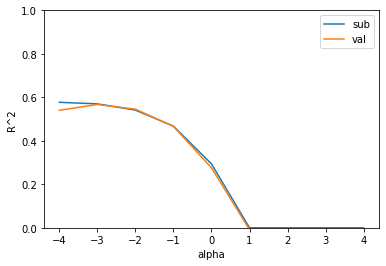

In [171]:
plt.plot(np.log10(alpha_list),sub_scores)
plt.plot(np.log10(alpha_list),val_scores)
plt.ylim(0, 1)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend(['sub','val'])
plt.show()

In [178]:
#최종 확인
lasso =Lasso(alpha=0.001,max_iter=10000)
lasso.fit(train_scaled,train_target)
print(lasso.score(train_scaled,train_target))
print(lasso.score(test_scaled,test_target))

0.5745761395965476
0.5419341982206634


C:\Users\dlehd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+02, tolerance: 1.074e+00
  model = cd_fast.enet_coordinate_descent(


In [180]:
#답 구하기
lasso.fit(train_max_scaled,train_max_target)
ans=lasso.predict(ques_scaled)

[10.47861471 14.85941092  5.79975619 ...  9.76748494  8.98890011
 12.2292422 ]


C:\Users\dlehd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e+02, tolerance: 1.294e+00
  model = cd_fast.enet_coordinate_descent(


In [181]:
#  #파일에 저장
#  f= open("lasso_submission.csv","w")
#  id = range(1,2925)
#  for i in id:
#      f.write(str(i) + ',' + str(ans[i-1]) + '\n')
#  f.close()

In [182]:
#예상 평가 점수 만들어보기
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score
lasso = Lasso()
lasso.fit(train_scaled,train_target)
pred = lasso.predict(test_scaled)
print(pred[:10])
print(test_target[:10])

print(NMAE(test_target,np.around(pred)))

[10.32112818 11.03013105  9.28438127  9.54760249 12.8300563  10.4682064
  9.27921245 10.11855316  9.10567804 10.32692853]
[ 8 13 13  9 13 14 10  9  6 13]
0.18018752547900532
